In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import pandas as pd
import os
from itertools import product
from argparse import Namespace
from option_hedging import compute_objective
from table_utils import *

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def expected_shortfall(vals, q):
    quantile = np.quantile(vals, q, axis=-1)
    return np.array([np.mean(vals[i, vals[i,:] <= quantile[i]]) for i in range(quantile.size)])

In [3]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Comparing methods

In [4]:
results = []
filenames = []
directory_str = "results/hedging/"
directory = os.fsencode(directory_str)
gradient_types = {"complete": "Complete PG", "naive": "Naive PG", "ppo": "PPO"}
objectives = {"cost": "Cost", "exponential_low": "Low RA", "exponential_high": "High RA"}
objectives_list = list(objectives.keys())
objective_types = ("cost", "exponential")
param_values = (None, 2e-8, 2e-7, 0.01)
baselines_str = {"delta": "Delta hedging", "no_hedging": "No hedging"}
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        filenames.append(filename)
        results.append(pickle.load( open( directory_str + filename, "rb" ) ))
        
num_runs = results[0]["num_runs"] 
columns = ["objective"] + list(baselines_str.values())
for e1,e2 in product(objectives.values(), gradient_types.values()):
    columns.append(e2+": "+e1)
    
objectives_list.append('es')
objectives["es"] = "Expected shortfall"
df_hedging = pd.DataFrame(columns=columns, index=np.arange(num_runs * len(objectives_list)), dtype="float")
for i in range(len(objectives)):
    df_hedging.loc[i*num_runs:(i+1)*num_runs-1, "objective"] = objectives[objectives_list[i]]
    
names = []
torch_cols = []
for i in range(len(results)):
    r = results[i]
    args = Namespace(**r)
    using_torch = True
    if "objective" in r:
        if r["objective"] == "exponential":
            objective_name = "exponential_low" if args.exp_param == 2e-8 else "exponential_high"
        else:
            objective_name = r["objective"]
    if filenames[i].startswith("option_hedging"):
        c = gradient_types[r["gradient_type"]] + ": " + objectives[objective_name]
    elif filenames[i].startswith("ppo_option_hedging"):
        c = gradient_types["ppo"]  + ": " + objectives[objective_name]
        using_torch = False
    else:
        idx = filenames[i].find("option_hedging") - 1
        c = baselines_str[filenames[i][:idx]]
    names.append(c)
    for j in range(len(objectives)):
        args.objective = objectives_list[j].split("_")[0]
        if args.objective == "exponential":
            args.exp_param = param_values[j]
        if objectives_list[j] == "es":
            if using_torch:
                vals = r["endvals"].detach().numpy()
            else:
                vals = r["endvals"]
            df_hedging.loc[j*num_runs:(j+1)*num_runs-1, c] = expected_shortfall(vals, param_values[j])
        elif using_torch:
            vals = torch.mean(compute_objective(r["endvals"], args), axis=-1)
            df_hedging.loc[j*num_runs:(j+1)*num_runs-1, c] = vals.detach().numpy()
        else:
            vals = np.mean(compute_objective(r["endvals"].astype(np.float64), args, using_torch=False), axis=-1)
            df_hedging.loc[j*num_runs:(j+1)*num_runs-1, c] = vals
    torch_cols.append(using_torch)
    
grouped_hedging, code_hedging = make_transposed_table(df_hedging,
                     ["objective"],
                     [c for c in columns if c != "objective"],
                     num_decimal = 4
                          )

table_filename = f"results/hedging.tex"
with open(table_filename, "w") as fp:
    fp.write(code_hedging)

In [5]:
grouped_hedging

objective                      Cost       Low RA       High RA  \
Delta hedging        mean  3.164530     3.795106  3.984704e+11   
                     std   0.003497     0.006518  5.958012e+11   
No hedging           mean  2.817881     3.770165  2.460009e+16   
                     std   0.005718     0.010649  4.923108e+16   
Complete PG: Cost    mean  0.805820  1014.077792  1.087326e+76   
                     std   0.364867  1148.065140  2.328318e+76   
Naive PG: Cost       mean  2.829353     4.092782  3.062579e+29   
                     std   0.021524     0.270383  6.826768e+29   
PPO: Cost            mean  1.308678  4904.884226  6.316097e+87   
                     std   0.024872  9985.490582  1.412322e+88   
Complete PG: Low RA  mean  2.534775     3.138404  5.883930e+40   
                     std   0.065149     0.146442  1.315687e+41   
Naive PG: Low RA     mean  3.052943     3.446132  1.257139e+06   
                     std   0.006105     0.011468  4.503352e+05   
PPO: Low RA          mean  2.861106     3.292031  4.512927e+09   
                     std   0.007280     0.011915  2.589995e+09   
Complete PG: High RA mean  3.032655     3.410531  6.375524e+05   
                     std   0.008090     0.010275  1.690088e+04   
Naive PG: High RA    mean  3.136318     3.544421  7.859167e+05   
                     std   0.010430     0.012898  2.439587e+04   
PPO: High RA         mean  2.816178     3.765712  1.383099e+16   
                     std   0.003571     0.005602  2.074311e+16   

objective                  Expected shortfall  
Delta hedging        mean       -1.297832e+08  
                     std         2.130223e+05  
No hedging           mean       -1.560357e+08  
                     std         5.548770e+05  
Complete PG: Cost    mean       -2.768770e+08  
                     std         4.222388e+07  
Naive PG: Cost       mean       -1.759051e+08  
                     std         1.722727e+07  
PPO: Cost            mean       -2.650797e+08  
                     std         1.517299e+07  
Complete PG: Low RA  mean       -1.284818e+08  
                     std         1.542597e+07  
Naive PG: Low RA     mean       -8.634088e+07  
                     std         1.951464e+06  
PPO: Low RA          mean       -1.064475e+08  
                     std         1.798750e+06  
Complete PG: High RA mean       -8.121034e+07  
                     std         4.454513e+05  
Naive PG: High RA    mean       -8.182021e+07  
                     std         4.583250e+05  
PPO: High RA         mean       -1.558767e+08  
                     std         5.150967e+05

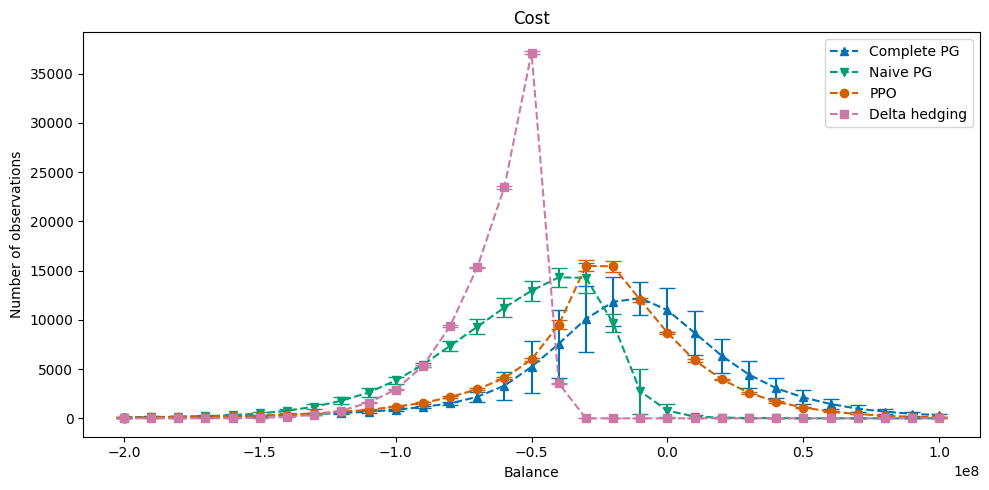

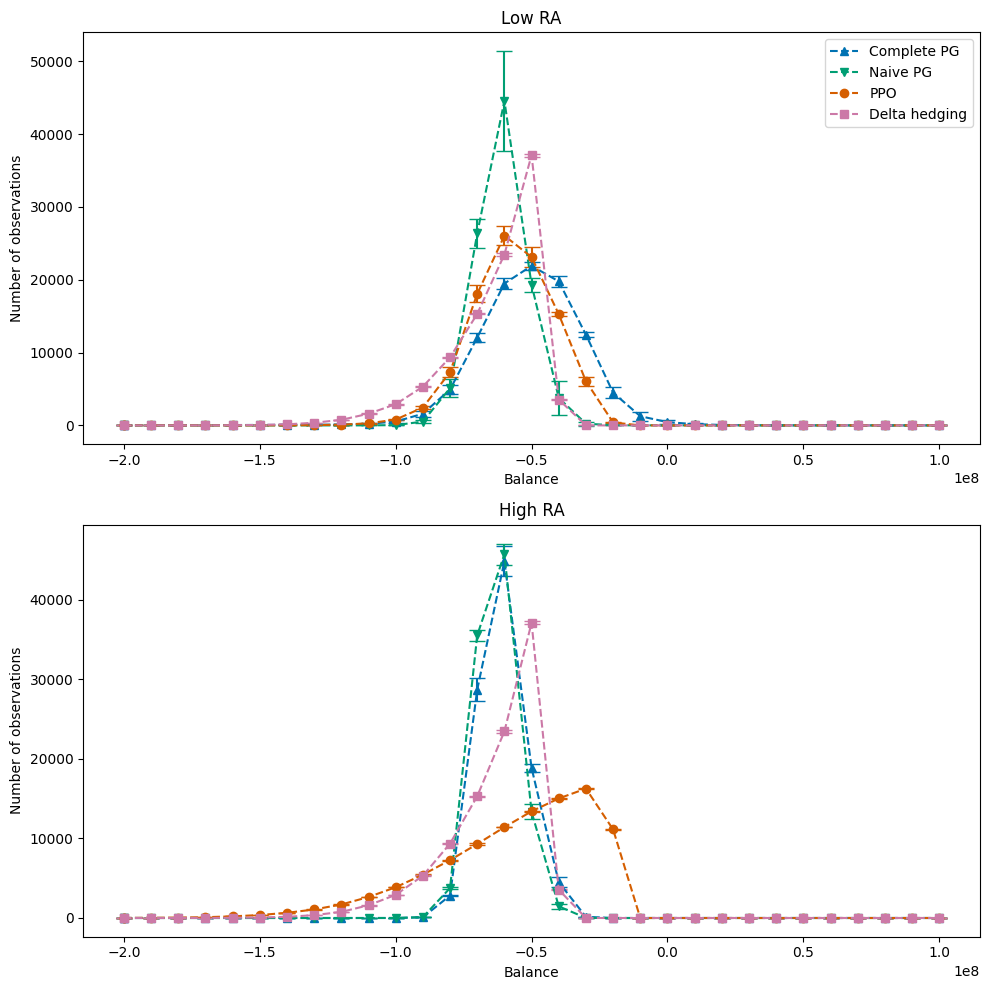

In [6]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--", "*--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2)
figs = [plt.subplots(i, 1, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
bins = (np.arange(-21, 11) + 0.5)*1e7
xs = (bins[1:] + bins[:-1])/2

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for ii in range(param_vals[fig_i]):
        ax = axs[fig_i] if param_vals[fig_i] == 1 else axs[fig_i][ii] 
        col_idx = 0
        for j in range(len(results)):
            r = results[j]
            if "objective" in r:
                if r["objective"] == "exponential":
                    objective_name = "exponential_low" if r["exp_param"] == 2e-8 else "exponential_high"
                else:
                    objective_name = r["objective"]
            if "objective" in r.keys() and r["objective"] == objective_types[fig_i]:
                idx = obj_list.index(objective_name)
                if idx == ii:
                    name = names[j].split(": ")[0]
                    if torch_cols[j]:
                        endvals = r["endvals"].detach().numpy()
                    else:
                        endvals = r["endvals"]
                    freqs = np.stack([np.histogram(endvals[n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                    std_values = np.std(freqs, axis=0)
                    mean_values = np.mean(freqs, axis=0)
                    ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                    ax.plot(xs[0], mean_values[0], markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                    col_idx += 1

        for j in range(len(results)):
            if names[j] == "Delta hedging":
                r = results[j]
                freqs = np.stack([np.histogram(r["endvals"][n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                std_values = np.std(freqs, axis=0)
                mean_values = np.mean(freqs, axis=0)
                ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, color=cols[col_idx], fmt=markers[col_idx], markersize=6)
                ax.plot(xs[0], mean_values[0], markers[col_idx], label=names[j], color=cols[col_idx], markersize=6)
                col_idx += 1
        ax.set_xlabel("Balance")
        ax.set_ylabel("Number of observations")
        ax.set_title(objectives[obj_list[ii]])
        if ii == 0:
            ax.legend()

    figs[fig_i][0].tight_layout()
    tikzplotlib.save('results/hedging_histogram_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()

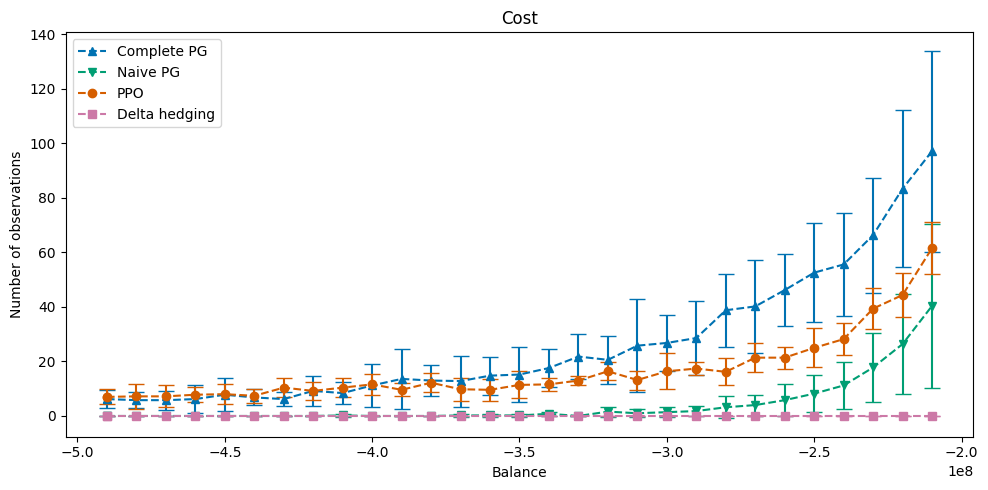

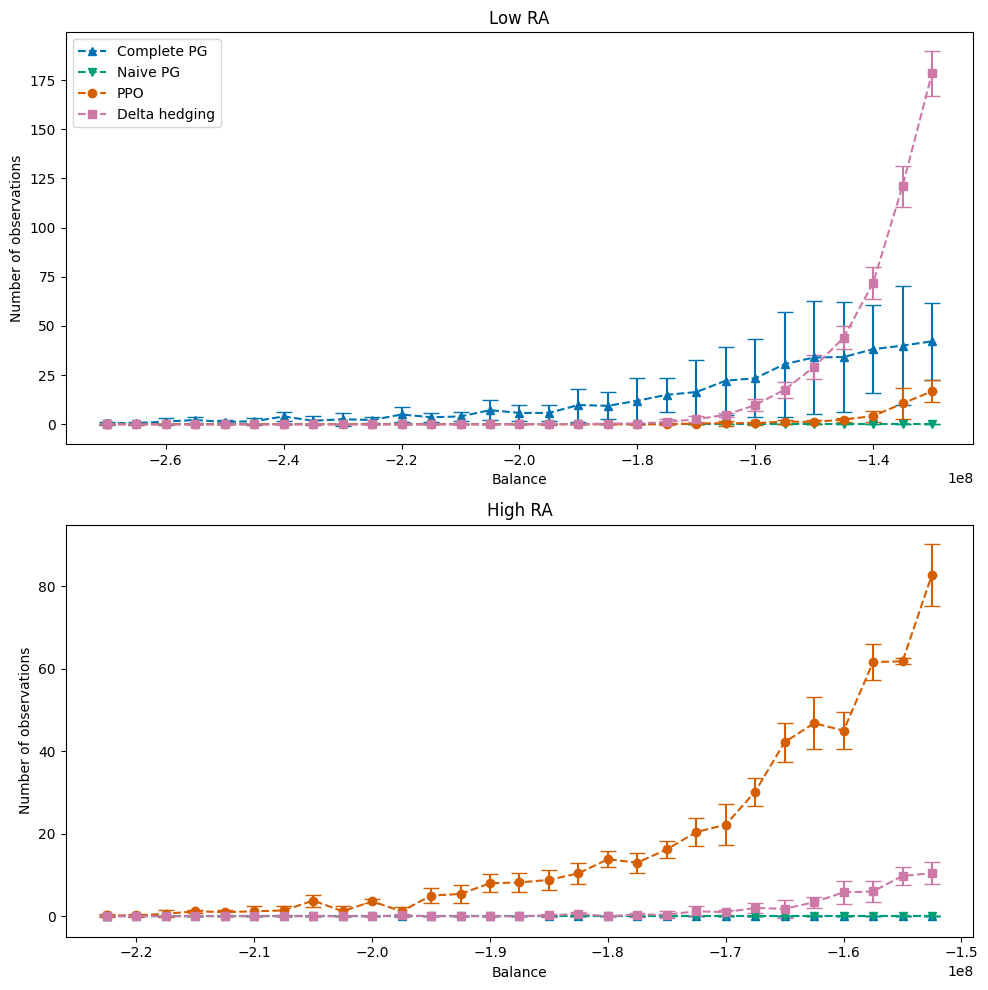

In [7]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--", "*--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
figs = [plt.subplots(i, 1, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
bins = {'cost': (np.arange(-50, -20) + 0.5)*1e7, 
        'exponential_low': (np.arange(-55, -25) + 0.5)*1e7/2,
        'exponential_high':  (np.arange(-90, -60) + 0.5)*1e7/4
       }
xs = {key: (b[1:] + b[:-1])/2 for key, b in bins.items()}

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for ii in range(param_vals[fig_i]):
        ax = axs[fig_i] if param_vals[fig_i] == 1 else axs[fig_i][ii] 
        col_idx = 0
        for j in range(len(results)):
            r = results[j]
            if "objective" in r:
                if r["objective"] == "exponential":
                    objective_name = "exponential_low" if r["exp_param"] == 2e-8 else "exponential_high"
                else:
                    objective_name = r["objective"]
            if "objective" in r.keys() and r["objective"] == objective_types[fig_i]:
                idx = obj_list.index(objective_name)
                if idx == ii:
                    name = names[j].split(": ")[0]
                    if torch_cols[j]:
                        endvals = r["endvals"].detach().numpy()
                    else:
                        endvals = r["endvals"]
                    freqs = np.stack([np.histogram(endvals[n,:], bins=bins[objective_name], density=False)[0] for n in range(num_runs)])  
                    std_values = np.std(freqs, axis=0)
                    mean_values = np.mean(freqs, axis=0)
                    ax.errorbar(xs[objective_name], mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                    ax.plot(xs[objective_name][0], mean_values[0], markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                    col_idx += 1
                    current_objective = objective_name

        for j in range(len(results)):
            if names[j] == "Delta hedging":
                r = results[j]
                freqs = np.stack([np.histogram(r["endvals"][n,:], bins=bins[current_objective], density=False)[0] for n in range(num_runs)])  
                std_values = np.std(freqs, axis=0)
                mean_values = np.mean(freqs, axis=0)
                ax.errorbar(xs[current_objective], mean_values, yerr=std_values, capsize=6, color=cols[col_idx], fmt=markers[col_idx], markersize=6)
                ax.plot(xs[current_objective][0], mean_values[0], markers[col_idx], label=names[j], color=cols[col_idx], markersize=6)
                col_idx += 1
        ax.set_xlabel("Balance")
        ax.set_ylabel("Number of observations")
        ax.set_title(objectives[obj_list[ii]])
        if ii == 0:
            ax.legend()

    figs[fig_i][0].tight_layout()

    tikzplotlib.save('results/hedging_histogram_tail_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()